In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 


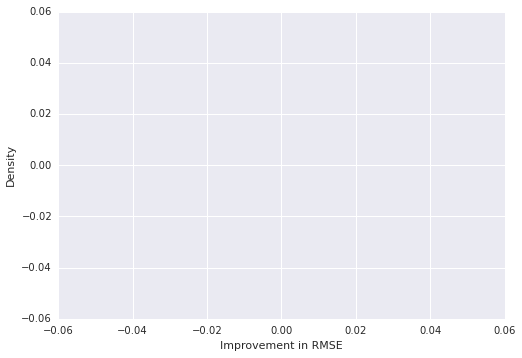

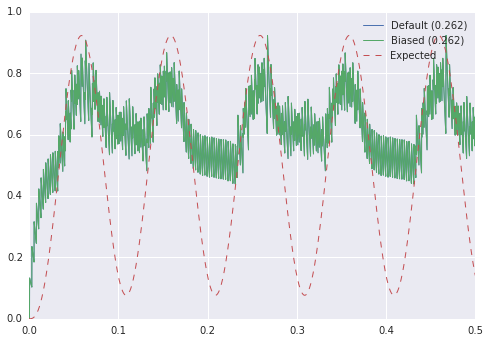

In [8]:
import numpy as np
import nengo
from nengo.solvers import Solver, LstsqL2
from nengo.utils.numpy import rmse

class BiasedSolver(Solver):
    
    def __init__(self, magnitude=1.0, solver=LstsqL2()):
        self.magnitude = magnitude
        self.solver = solver
        self.bias = None
        super(BiasedSolver, self).__init__()
        
    def __call__(self, A, Y, rng=None, E=None):
        if self.bias is not None:
            raise RuntimeError("can only use %s once; create a new instance "
                               "per connection" % self.__class__.__name__)
        scale = A.max()  # to make regularization consistent
        AB = np.empty((A.shape[0], A.shape[1] + 1))
        AB[:, :-1] = A
        AB[:, -1] = scale * self.magnitude
        #self.bias = 0
        #return self.solver.__call__(A, Y, rng=rng, E=E)
    
        XB, solver_info = self.solver.__call__(AB, Y, rng=rng, E=E)
        #assert np.allclose(self.solver.__call__(AB, Y, rng=rng, E=E)[0], XB)
        solver_info['bias'] = self.bias = XB[-1, :] * scale
        return XB[:-1, :], solver_info

    def bias_function(self):
        return lambda x: None if self.bias is None else x * self.bias

trials = []
for _ in range(10):
    with nengo.Network() as model:

        function = lambda x: 1 - x**2
        tau = 0.01
        bias_magnitude = 1  # affects relative regularization
        solver = nengo.solvers.NnlsL2(reg=0)

        stim = nengo.Node(output=lambda t: np.cos(5*t*2*np.pi))
        x = nengo.Ensemble(10, 1, neuron_type=nengo.LIF())
        unbiased_output = nengo.Node(size_in=1)
        biased_output = nengo.Node(size_in=1)

        nengo.Connection(stim, x, synapse=None)
        nengo.Connection(x, unbiased_output, function=function, synapse=None, solver=solver)
        conn = nengo.Connection(
            x, biased_output, function=function, synapse=None,
            solver=BiasedSolver(bias_magnitude, solver=solver))
        nengo.Connection(
            nengo.Node(output=bias_magnitude), biased_output,
            function=conn.solver.bias_function(), synapse=None)

        p_unbiased_output = nengo.Probe(unbiased_output, synapse=tau)
        p_biased_output = nengo.Probe(biased_output, synapse=tau)
        p_stim = nengo.Probe(stim)

    with nengo.Simulator(model, dt=0.0001) as sim:
        sim.run(0.5)

    #print("Bias: %s" % sim.data[conn].solver_info['bias'])

    biased = sim.data[p_biased_output]
    unbiased = sim.data[p_unbiased_output]
    expected = nengo.Lowpass(tau).filt(function(sim.data[p_stim]), dt=sim.dt)
    
    trials.append(rmse(unbiased, expected) - rmse(biased, expected))
    
pylab.figure()
sns.kdeplot(np.asarray(trials))
pylab.xlabel("Improvement in RMSE")
pylab.ylabel("Density")
pylab.show()


pylab.figure()
pylab.plot(sim.trange(), unbiased, lw=1, label="Default (%.3f)" % rmse(unbiased, expected))
pylab.plot(sim.trange(), biased, lw=1, label="Biased (%.3f)" % rmse(biased, expected))
pylab.plot(sim.trange(), expected, lw=1, linestyle='--', label="Expected")
pylab.legend()
pylab.ylim(0, 1)
pylab.show()